Обучить детектор объектов с помощью TensorFlow Object Detection API

Источник: туториал по **TensorFlow Object Detection API**

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_object_detection.ipynb#scrollTo=Gb_siXKcnnGC

### Установка и импорт


In [ ]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [ ]:
# клонирование репозитория tensorflow models
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3482, done.
remote: Counting objects: 100% (3482/3482), done.
remote: Compressing objects: 100% (2910/2910), done.
remote: Total 3482 (delta 905), reused 1492 (delta 519), pack-reused 0
Receiving objects: 100% (3482/3482), 46.91 MiB | 16.30 MiB/s, done.
Resolving deltas: 100% (905/905), done.


In [ ]:
# установка API tensorflow OD

%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1696118 sha256=50ecb637f3d52e38a4e01da78c0da2abb5ba725efc4770fb32e44c0afda6bc87
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1_guasv/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=ae9386cb1f24a7e5a375f8de4fab51ffac20d87db8b6df6e610e2b3be053fd81
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/0



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Модели и изображения

In [ ]:
def load_image_into_numpy_array(path):
    # принимает путь к файлу, возвращает numpy массив (ширина, высота, 3 канала RGB)

  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)


# весь список моделей репозитория, обученных на датасете Coco-2017
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

IMAGES_FOR_TEST = {
  'Dogs' : 'models/research/object_detection/test_images/image1.jpg',
  'Coconut milk' : 'https://upload.wikimedia.org/wikipedia/commons/e/eb/Cononut_milk.JPG',
  'Naxos Taverna' : 'https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg',
  'Beatles' : 'https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg',
  'Birds' : 'https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg',
}

# список кортежей для моделей (Mask-RCNN, к примеру) с ключевыми точками (плечи, конечности и т.д.).
COCO17_HUMAN_POSE_KEYPOINTS = [(0, 1), (0, 2), (1, 3), (2, 4),
 (0, 5), (0, 6), (5, 7), (7, 9), (6, 8), (8, 10), (5, 6), (5, 11), (6, 12),
 (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)]

### Загрузка карты меток для отображения

In [ ]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

### Загрузка модели

In [ ]:
model_display_name = 'CenterNet HourGlass104 Keypoints 512x512'
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:CenterNet HourGlass104 Keypoints 512x512
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1


In [ ]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...


model loaded!


### Загрузка изображения

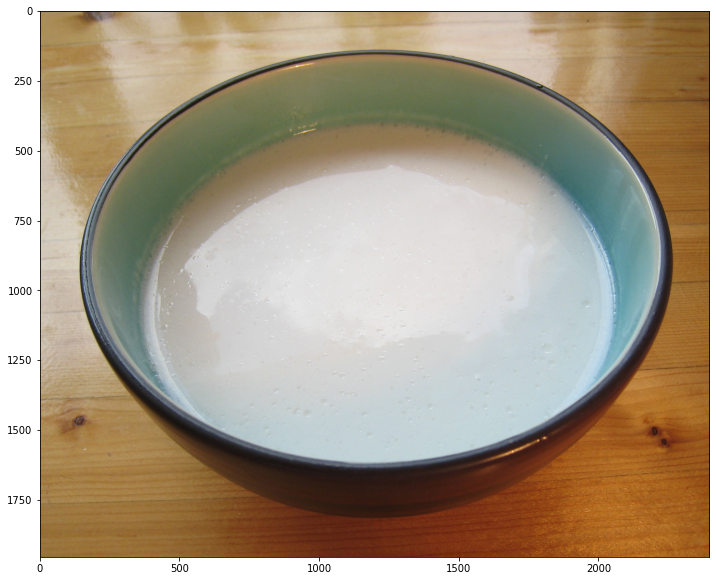

In [ ]:
def load_image(image_name, visualize=True):
  
  selected_image = image_name
  flip_image_horizontally = False
  convert_image_to_grayscale = False

  image_path = IMAGES_FOR_TEST[selected_image]
  image_np = load_image_into_numpy_array(image_path)

  # отразить
  if(flip_image_horizontally):
   image_np[0] = np.fliplr(image_np[0]).copy()

  # преобразование в градации серого
  if(convert_image_to_grayscale):
    image_np[0] = np.tile(
      np.mean(image_np[0], 2, keepdims=True), (1, 1, 3)).astype(np.uint8)


  if visualize:
    plt.figure(figsize=(12,16))
    plt.imshow(image_np[0])
    plt.show()

  return image_np


image_np = load_image('Coconut milk')

### Инференс

In [ ]:
results = hub_model(image_np)

result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_boxes', 'detection_keypoint_scores', 'num_detections', 'detection_scores', 'detection_keypoints', 'detection_classes'])


### Визуализация результатов

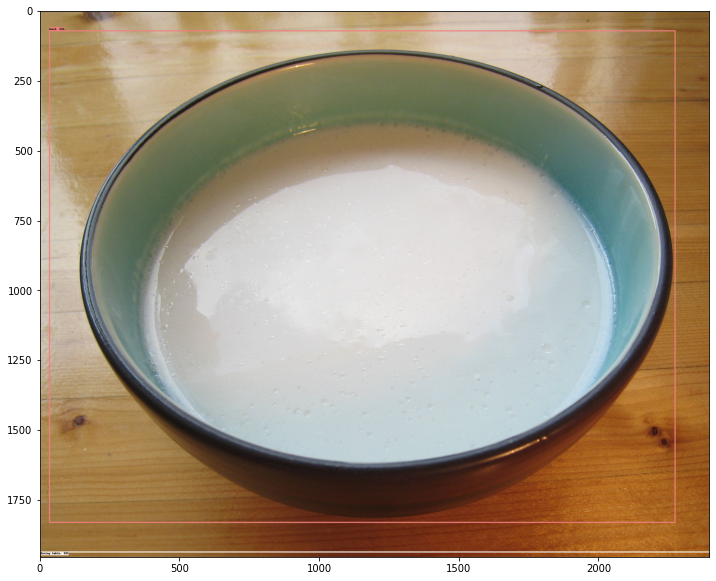

In [ ]:
def visual(image_np, visualize=True):


  label_id_offset = 0
  image_np_with_detections = image_np.copy()

  # ключевые точки, если есть
  keypoints, keypoint_scores = None, None
  if 'detection_keypoints' in result:
    keypoints = result['detection_keypoints'][0]
    keypoint_scores = result['detection_keypoint_scores'][0]

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections[0],
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        keypoints=keypoints,
        keypoint_scores=keypoint_scores,
        keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

  if visualize:
    plt.figure(figsize=(12, 16))
    plt.imshow(image_np_with_detections[0])
    plt.show()

CenterNet вывел bounding-box с меткой "миска". 

В этом случае плюс-минус удачно.

### Теперь модель Mask-RCNN и ее одновременная сегментация с детектированием

In [ ]:
model_display_name = 'Mask R-CNN Inception ResNet V2 1024x1024'
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

print('loading model...')
hub_model_mask = hub.load(model_handle)
print('model loaded!')

Selected model:Mask R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1
loading model...
model loaded!


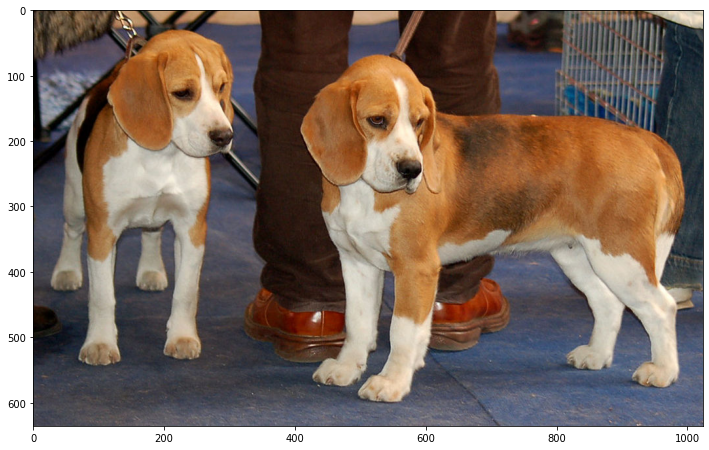

In [ ]:
image_for_mask_rcnn = load_image('Dogs')

In [ ]:
mask_rcnn_results = hub_model_mask(image_for_mask_rcnn)

mask_rcnn_result = {key:value.numpy() for key,value in mask_rcnn_results.items()}
print(result.keys())

dict_keys(['detection_boxes', 'detection_keypoint_scores', 'num_detections', 'detection_scores', 'detection_keypoints', 'detection_classes'])


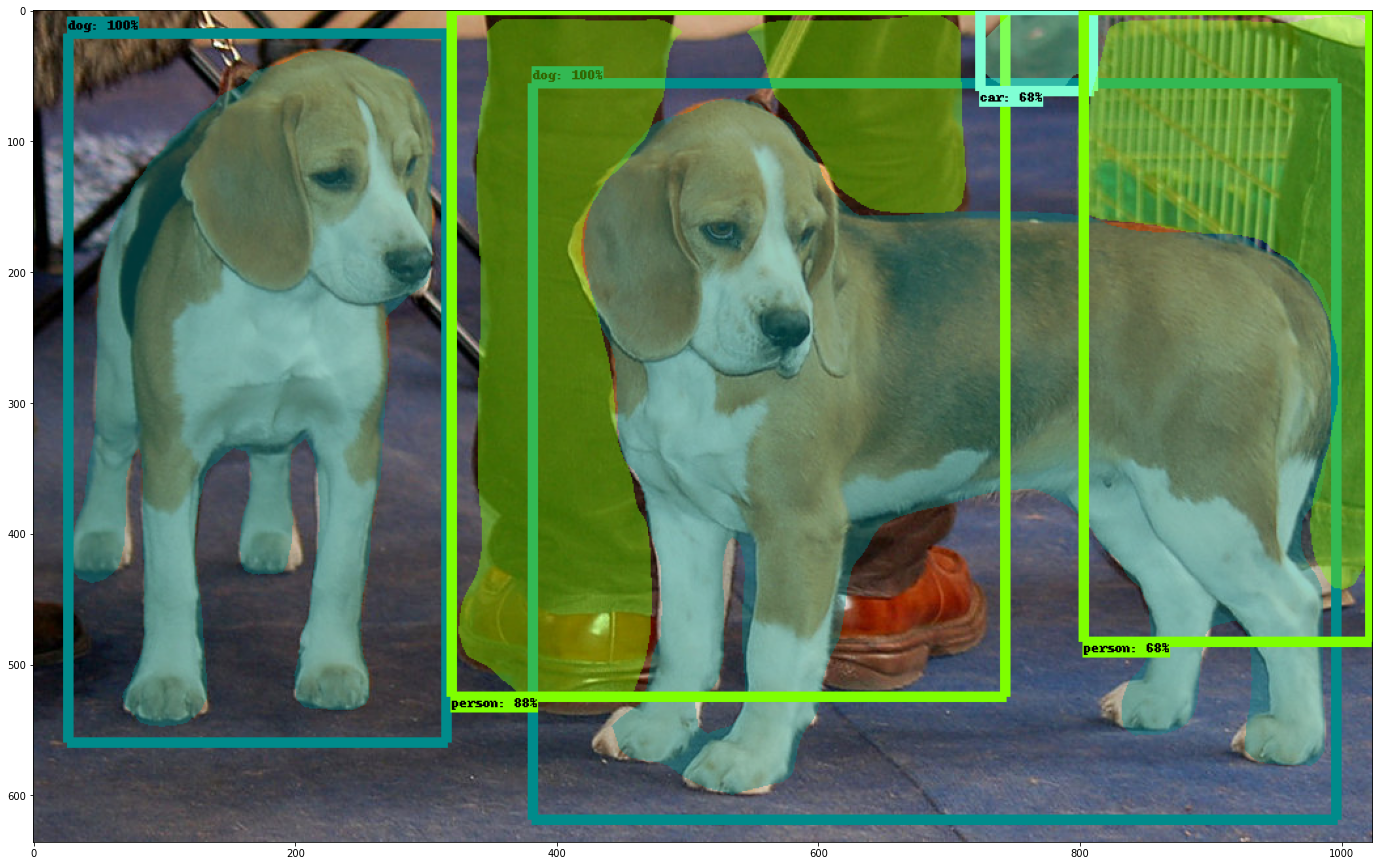

In [ ]:
# нанести маски
image_np_with_mask = image_for_mask_rcnn.copy()

if 'detection_masks' in mask_rcnn_result:
  # необходимо преобразовать в тензоры
  detection_masks = tf.convert_to_tensor(mask_rcnn_result['detection_masks'][0])
  detection_boxes = tf.convert_to_tensor(mask_rcnn_result['detection_boxes'][0])

  # ресайз до размера изображения
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes,
              image_for_mask_rcnn.shape[1], image_for_mask_rcnn.shape[2])
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                      tf.uint8)
  mask_rcnn_result['detection_masks_reframed'] = detection_masks_reframed.numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_mask[0],
      mask_rcnn_result['detection_boxes'][0],
      (mask_rcnn_result['detection_classes'][0] + 0).astype(int),
      mask_rcnn_result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      instance_masks=mask_rcnn_result.get('detection_masks_reframed', None),
      line_thickness=8)

plt.figure(figsize=(24,24))
plt.imshow(image_np_with_mask[0])
plt.show()

Я ожидал сегментацию на собаках, но модель видимо обучалась на людях. 

Впрочем, не хочу что-то менять. И остановлюсь здесь
.